## Imports & Setup

In [1]:
import os
import pandas as pd
# import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/preprocessed_train.csv')

In [4]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,1,1,0,2,1,1,2,4,1,106,0
1,city_83,0.923,1,1,0,2,1,3,1,2,1,69,0
2,city_16,0.910,1,1,0,2,1,2,1,1,1,4,0
3,city_64,0.666,1,1,0,2,1,3,1,4,1,26,0
4,city_100,0.887,1,0,0,2,1,2,1,4,1,88,1


In [5]:
df.shape

(18359, 13)

In [6]:
X = df.drop(['target'],axis=1)
y = df['target']

In [7]:
# Encode column 'city'
enc = LeaveOneOutEncoder(cols=['city'])
X_enc = enc.fit_transform(X,y)
X_enc.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.125000,0.689,1,1,0,2,1,1,2,4,1,106
1,0.099291,0.923,1,1,0,2,1,3,1,2,1,69
2,0.093164,0.910,1,1,0,2,1,2,1,1,1,4
3,0.101695,0.666,1,1,0,2,1,3,1,4,1,26
4,0.159259,0.887,1,0,0,2,1,2,1,4,1,88


In [8]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X_enc)

In [9]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=3)

In [10]:
# Confirm there's positive class in the test set.
y_test.value_counts()

0    4813
1     695
Name: target, dtype: int64

## 1. Try Logistic regression 

In [11]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

score(y_test, y_pred, pos_label=1,average='binary') 
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,  695],
       [   0, 4813]])

### As data is imbalanced so there's no positive class predicted, therefore Recall is zero, 
### Precision and fscore are ill-defined.

In [12]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

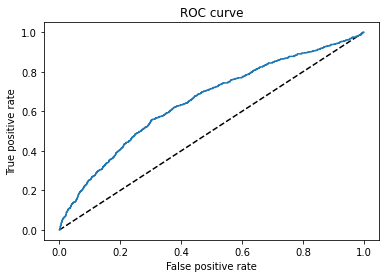

In [13]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [14]:
auc = metrics.auc(fpr,tpr)
print('AUC:{0:.3f}'.format(auc))

AUC:0.653


### As you can see the overall, the performance from model logistic regression is not very ideal. 
### And as I showed you some of the result in our 1:1 on 9/29, I tried multiple models with the over_sampled data(SMOTE), and realized that DecisionTreeClassifier has extremely good performance, 
### so I tried to run the DecisionTree on the original data (not over_sampled one), and got some really weird result.
### Please find the result as below:

## 2. Try DecisionTree model

In [15]:
model2 = DecisionTreeClassifier(random_state=4)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

# get precision, recall, fscore
score(y_test, y_pred2, pos_label=1,average='binary')   

(1.0, 1.0, 1.0, None)

In [16]:
# get accuracy
accuracy_score(y_test,y_pred2)

1.0

In [17]:
(y_pred2 == y_test).value_counts()

True    5508
Name: target, dtype: int64

## Turns out this model predicts everything correctly on this test set, no missclassification at all. Does this normally happen???? 
## Does this still mean the model could be overfitting? for the next step Shall I add some penalty on it to avoid overfitting? 

## Even this one model seems to be perfect for this dataset, I still tried to over sampling the train data and run multiple models on it and summarized the result. Please find this process as below:

## 3. Train model with SMOTE method

In [18]:
os = SMOTE(random_state=0)
#columns = X_train.columns

#os_data_X,os_data_y=os.fit_sample(X_train, y_train)
X_os, y_os=os.fit_sample(X_train, y_train.ravel())

In [19]:
print(X_os.shape)
print(y_os.shape)

(22242, 12)
(22242,)


In [20]:
# make sure the numbers of positive and negative class are the same
np.unique(y_os,return_counts=True)

(array([0, 1]), array([11121, 11121]))

In [21]:
# Split the over sampled train_data: X_os, y_os to a new train_test set.
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3, random_state=0)

### First try logistic regression on the new train data 

In [22]:
logreg = LogisticRegression()
logreg.fit(X_os_train, y_os_train)

LogisticRegression()

In [23]:
y_os_pred = logreg.predict(X_os_test)
y_os_pred_proba = logreg.predict_proba(X_os_test)[:,1]
fpr, tpr, threshold = roc_curve(y_os_test, y_os_pred_proba)
precision, recall, fscore,support = score(y_os_test, y_os_pred, pos_label=1,average='binary')

In [24]:
print('precision:', precision, 'recall:', recall, 'fscore:', fscore, 'auc:',metrics.auc(fpr,tpr))

precision: 0.6340131099781501 recall: 0.5211014666267585 fscore: 0.5720387711516348 auc: 0.6409435070047176


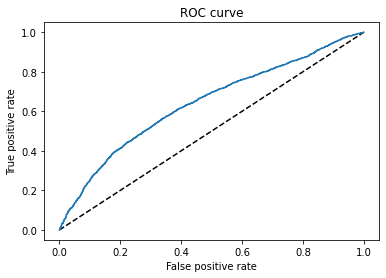

In [25]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [26]:
# create a new dataframe for predicted probability and labels(in the y_os_test)
predProba_label = pd.DataFrame()
predProba_label['proba'] = y_os_pred_proba
predProba_label['label'] = np.array(y_os_test)

predProba_label.head()

,proba,label
0,0.663640,0
1,0.398595,0
2,0.574733,1
3,0.680315,0
4,0.447122,0


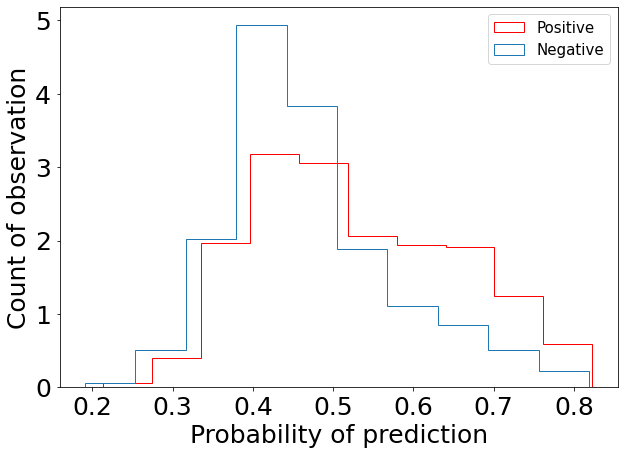

In [27]:
# Make the histogram
plt.figure(figsize=(10,7))
plt.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
plt.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
plt.xlabel('Probability of prediction', fontsize=25)
plt.ylabel('Count of observation', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

### Then try different models on the oversampled data set.

In [28]:
model_res = {}

models = {'LR': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'SVC': SVC(probability=True, random_state=4),
         'DT': DecisionTreeClassifier(random_state=4),
         'RF': RandomForestClassifier(random_state=4),
         'GB': GradientBoostingClassifier(random_state=4)}

for i, model in models.items():
    start = time.time()
    model.fit(X_os_train, y_os_train)
    end = time.time()
    fit_time = end - start
    
    y_os_pred_proba = model.predict_proba(X_os_test)[:,1]
    fpr,tpr,_ = roc_curve(y_os_test, y_os_pred_proba,pos_label=1)
    auc = metrics.auc(fpr,tpr)
    
    start = time.time()
    y_os_pred = model.predict(X_os_test)
    end = time.time()
    pred_time = end - start
    
    precision, recall, fscore, _ = score(y_os_test, y_os_pred, pos_label=1,average='binary')    
    model_res[i] = accuracy_score(y_os_test,y_os_pred), precision, recall, fscore, auc, fit_time, pred_time

In [29]:
# Put the model evaluation result in a data frame.
df_model_eval = pd.DataFrame(model_res.values(),index=model_res.keys(),
                        columns=['accuracy','precision','recall','fscore','auc','fit_time','pred_time'])

df_model_eval = df_model_eval.round(3)
df_model_eval

,accuracy,precision,recall,fscore,auc,fit_time,pred_time
LR,0.610,0.634,0.521,0.572,0.641,0.019,0.000
KNN,0.759,0.714,0.865,0.782,0.828,0.184,0.483
SVC,0.653,0.668,0.611,0.638,0.709,33.354,1.251
DT,0.998,1.000,0.996,0.998,0.998,0.033,0.001
RF,0.971,0.982,0.960,0.971,0.997,1.047,0.079
GB,0.935,0.931,0.940,0.935,0.987,1.282,0.009


## Pick model DecisionTreeClassifier as it has the highest score and the fit_time, pred_time are the second shortest

In [30]:
finmodel = DecisionTreeClassifier(random_state=4)
finmodel.fit(X_os_train, y_os_train)
fin_y_pred = finmodel.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')    

(0.9985632183908046, 1.0, 0.9992810927390366, None)

In [31]:
(fin_y_pred == y_test).value_counts()

True     5507
False       1
Name: target, dtype: int64

## What shall I do for the next step? I am a bit lost now as it didn't go as I planned.

## My plan was to: 
1. train multiple models on the original data set (without oversampling), 
2. get model results
3. try to optimize the model performance by adopting SMOTE
4. get model results again and pick the best model
5. use gridsearchcv to tune best model's hyper parameters to optimize model.



Questions from me:
1) as now I figured out the DecisionTree model is performing so well on the original data, so I am not sure if it still makes sense to 
do the SMOTE trick with other models.

2) as I've asked you earlier in this note book, when the model performs perfectly on the test set, what shall we do for the next? As I've  never run into this situation so far...